In [ ]:
from docx import Document
import pandas as pd

doc = Document(r"C:\Users\anast\OneDrive\Desktop\Gon data.docx")

tables = doc.tables
table = tables[0]

data = []
for row in table.rows:
    cells = [cell.text.strip() for cell in row.cells]
    data.append(cells)

df = pd.DataFrame(data[1:], columns=data[0])
df.to_csv("gonorrhea_mic_data.csv", index=False)

print(df.head())


  Sample          Run Location     Date Anatomic Site  PEN  TET  SPEC    CFX  \
0   101M  SRR16683613  Vietnam  2019-11      Urethral   64    4  <=16   0.06   
1   102M  SRR16683612  Vietnam  2019-05      Urethral    2    4  <=16  0.015   
2  103MA  SRR16683584  Vietnam     2019      Urethral   32  >64  <=16   0.06   
3  103MB  SRR16683870  Vietnam     2019      Urethral  >64    4  <=16  0.125   
4   112M  SRR16683759  Vietnam  2019-09      Urethral    1    2  <=16   0.25   

     CRO CIP    AZI    ZOL  
0   0.06  32   0.25  0.125  
1   0.03  16    0.5  0.125  
2   0.06  16  0.125   0.06  
3  0.125  32   0.25  0.125  
4   0.06  16   0.25  0.125  


In [ ]:
df = pd.read_csv("gonorrhea_mic_data.csv")

# Clean MIC values
def clean_mic(value):
    try:
        if isinstance(value, str):
            value = value.strip()
            if value.startswith("<="):
                return float(value[2:])
            elif value.startswith(">"):
                return float(value[1:]) + 1
            elif value.startswith("<"):
                return float(value[1:]) - 0.01
            else:
                return float(value)
        return float(value)
    except:
        return None

# Clean the MIC columns
mic_cols = ['PEN', 'TET', 'SPEC', 'CFX', 'CRO', 'CIP', 'AZI', 'ZOL']
for col in mic_cols:
    df[col] = df[col].apply(clean_mic)
    df.to_csv("cleaned_gonorrhea_data.csv", index=False)  # Save after cleaning
df["CIP_Resistant"] = df["CIP"].apply(lambda x: 1 if x > 0.06 else 0)

In [4]:
df["CIP_Resistant"] = df["CIP"].apply(lambda x: 1 if x > 0.06 else 0)
df.to_csv("cleaned_gonorrhea_data.csv", index=False)

In [5]:
df = pd.read_csv("cleaned_gonorrhea_data.csv")
from sklearn.model_selection import train_test_split

features = ['PEN', 'TET', 'SPEC', 'CFX', 'CRO', 'AZI', 'ZOL']
X = df[features]
y = df['CIP_Resistant']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[13  5]
 [ 2 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.94      0.97      0.95        74

    accuracy                           0.92        92
   macro avg       0.90      0.85      0.87        92
weighted avg       0.92      0.92      0.92        92



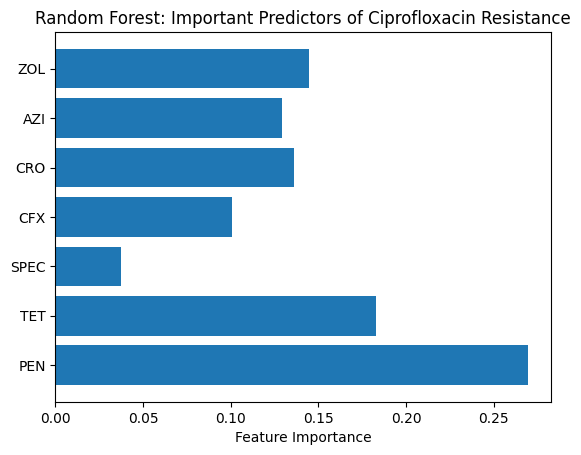

In [7]:
# Feature importance
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest: Important Predictors of Ciprofloxacin Resistance")
plt.show()


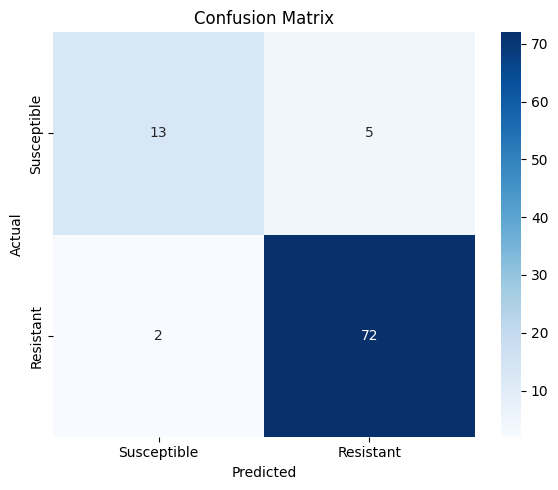

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_recall_curve
)

df = pd.read_csv("cleaned_gonorrhea_data.csv")

features = ['PEN', 'TET', 'SPEC', 'CFX', 'CRO', 'AZI', 'ZOL']
X = df[features]
y = df['CIP_Resistant']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Susceptible", "Resistant"], 
            yticklabels=["Susceptible", "Resistant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

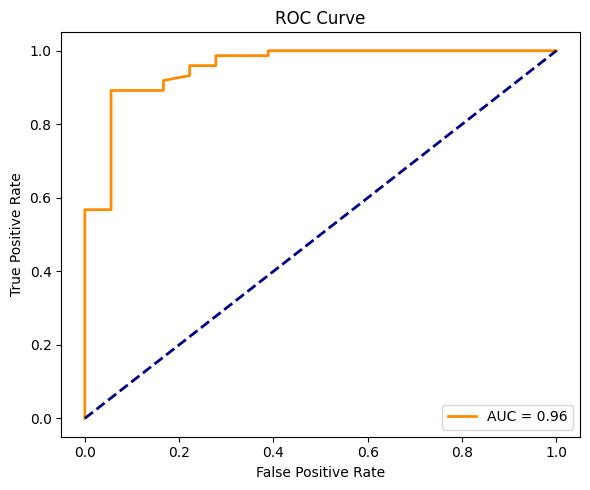

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

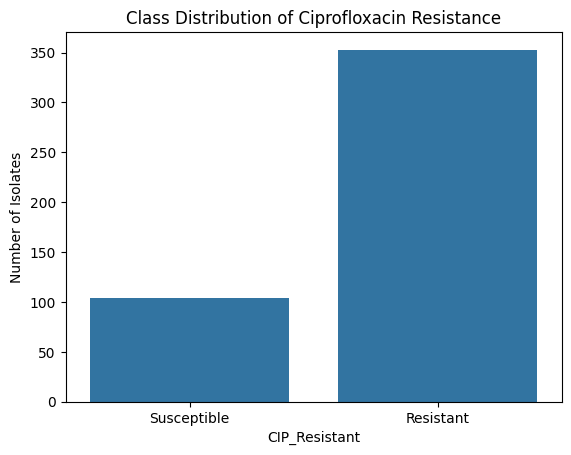

In [ ]:
# Class distribution
sns.countplot(x="CIP_Resistant", data=df)
plt.title("Class Distribution of Ciprofloxacin Resistance")
plt.xticks([0, 1], ["Susceptible", "Resistant"])
plt.ylabel("Number of Isolates")
plt.show()